In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import numpy as np; np.random.seed(42)
import glob, os, cv2, json
from PIL import Image
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from PIL import ImageDraw
import cv2
from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import display
import pickle
# %matplotlib notebook

In [2]:
grasp_names = ["Large Diameter", "Small Diameter", "Medium Wrap", "Adducted Thumb", "Light Tool",
    "Prismatic 4 Finger", "Prismatic 3 Finger", "Prismatic 2 Finger", "Palmar Pinch",
    "Power Disk", "Power Sphere", "Precision Disk", "Precision Sphere", "Tripod", "Fixed Hook",
    "Lateral", "Index Finger Extension", "Extension Type", "Distal", "Writing Tripod", "Tripod Variation",
    "Parallel Extension", "Adduction Grip", "Tip Pinch", "Lateral Tripod", "Sphere 4-Finger", "Quadpod",
    "Sphere 3-Finger", "Stick", "Palmar", "Ring", "Ventral", "Inferior Pincer"]

In [3]:
model_name = f'SegNet_hands_nosupckpt27_seed0_ROI350_YCB75'
im_dir = f"/home/mohit/VOS/epic-affordances/evaluation/epic-roi/data/roi-data/images"
pred_dir = f"/home/mohit/VOS/epic-affordances/training/inferred_IHdata/epicaff_benchmark/{model_name}"
out_dir = f"./inferred_blobs/epicaff_benchmark/{model_name}"
annot_path = f"/home/mohit/VOS/epic-affordances/evaluation/epic-roi/data/annotated_frames.json"
metadata = json.load(open(annot_path, 'r'))

os.makedirs(out_dir, exist_ok=True)
im_list = [f"{im_dir}/{i[:-4]}.jpg" for i in metadata['val_images']]

In [4]:
def non_max_suppression_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

def detect_and_createbb(hm, img_shape, nms=False):
    image = hm # smoothed out predictions.
    blobs_log = blob_log(image, min_sigma=30, max_sigma=200, num_sigma=30, threshold=.01)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    
    boxes = np.zeros((len(blobs_log), 4))
    scores = np.zeros((len(blobs_log)))
    boxes[:, 0] = blobs_log[:, 1] - blobs_log[:, 2]
    boxes[:, 1] = blobs_log[:, 0] - blobs_log[:, 2]
    boxes[:, 2] = blobs_log[:, 1] + blobs_log[:, 2]
    boxes[:, 3] = blobs_log[:, 0] + blobs_log[:, 2]
#     print(boxes.shape, npimg.shape)

    boxes[:, 0] = np.clip(boxes[:, 0], 0, img_shape[1]-1)
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img_shape[1]-1)
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img_shape[0]-1)
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img_shape[0]-1)
    boxes = boxes.astype(np.int32)
    
    for ind in range(len(boxes)):
        scores[ind] = np.mean(image[boxes[ind,1]:boxes[ind, 3], boxes[ind,0]:boxes[ind, 2]].astype(np.float32))
    
    if nms:
        boxes_nms = non_max_suppression_fast(boxes, scores, 0.3)
        return boxes_nms, scores
    return boxes, scores
    

In [5]:
def draw_bbox(img, bbox, color="white", text=None):
    if bbox is None:
        return img
    source_img = img.convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline=color, width=4)
    if text is not None:
        draw.text((bbox[0]//2+bbox[2]//2, bbox[1]//2+bbox[3]//2), text)
#     source_img.show()
    return source_img

def crop_bbox(img, bbox):
    return img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])


In [6]:
for IIII in tqdm(range(len(im_list))):
    im_name = im_list[IIII]
    hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
    fname = os.path.splitext(os.path.basename(im_name))[0]
    # roi_name = roi_dir + "/" + os.path.basename(im_name)[:-4] + '_hm.png'

    img = Image.open(im_name)
    npimg = np.array(img)
    hm = np.load(hm_name)
    # roi = Image.open(roi_name)

    for j in range(33):    
        sigmaX = 3
        hm[:,:,j] = cv2.GaussianBlur(hm[:,:,j]+0, (int(sigmaX*6+1), int(sigmaX*6+1)), sigmaX=sigmaX)

    outs = Parallel(n_jobs=33, prefer="threads")(delayed(detect_and_createbb)(hm[:, :, ind], npimg.shape, False) \
                                                     for ind in range(hm.shape[2]))
    with open(f"{out_dir}/{os.path.basename(im_name)[:-3]}.pkl", "wb") as f:
        pickle.dump(outs, f)

100%|██████████| 32/32 [1:14:17<00:00, 139.30s/it]


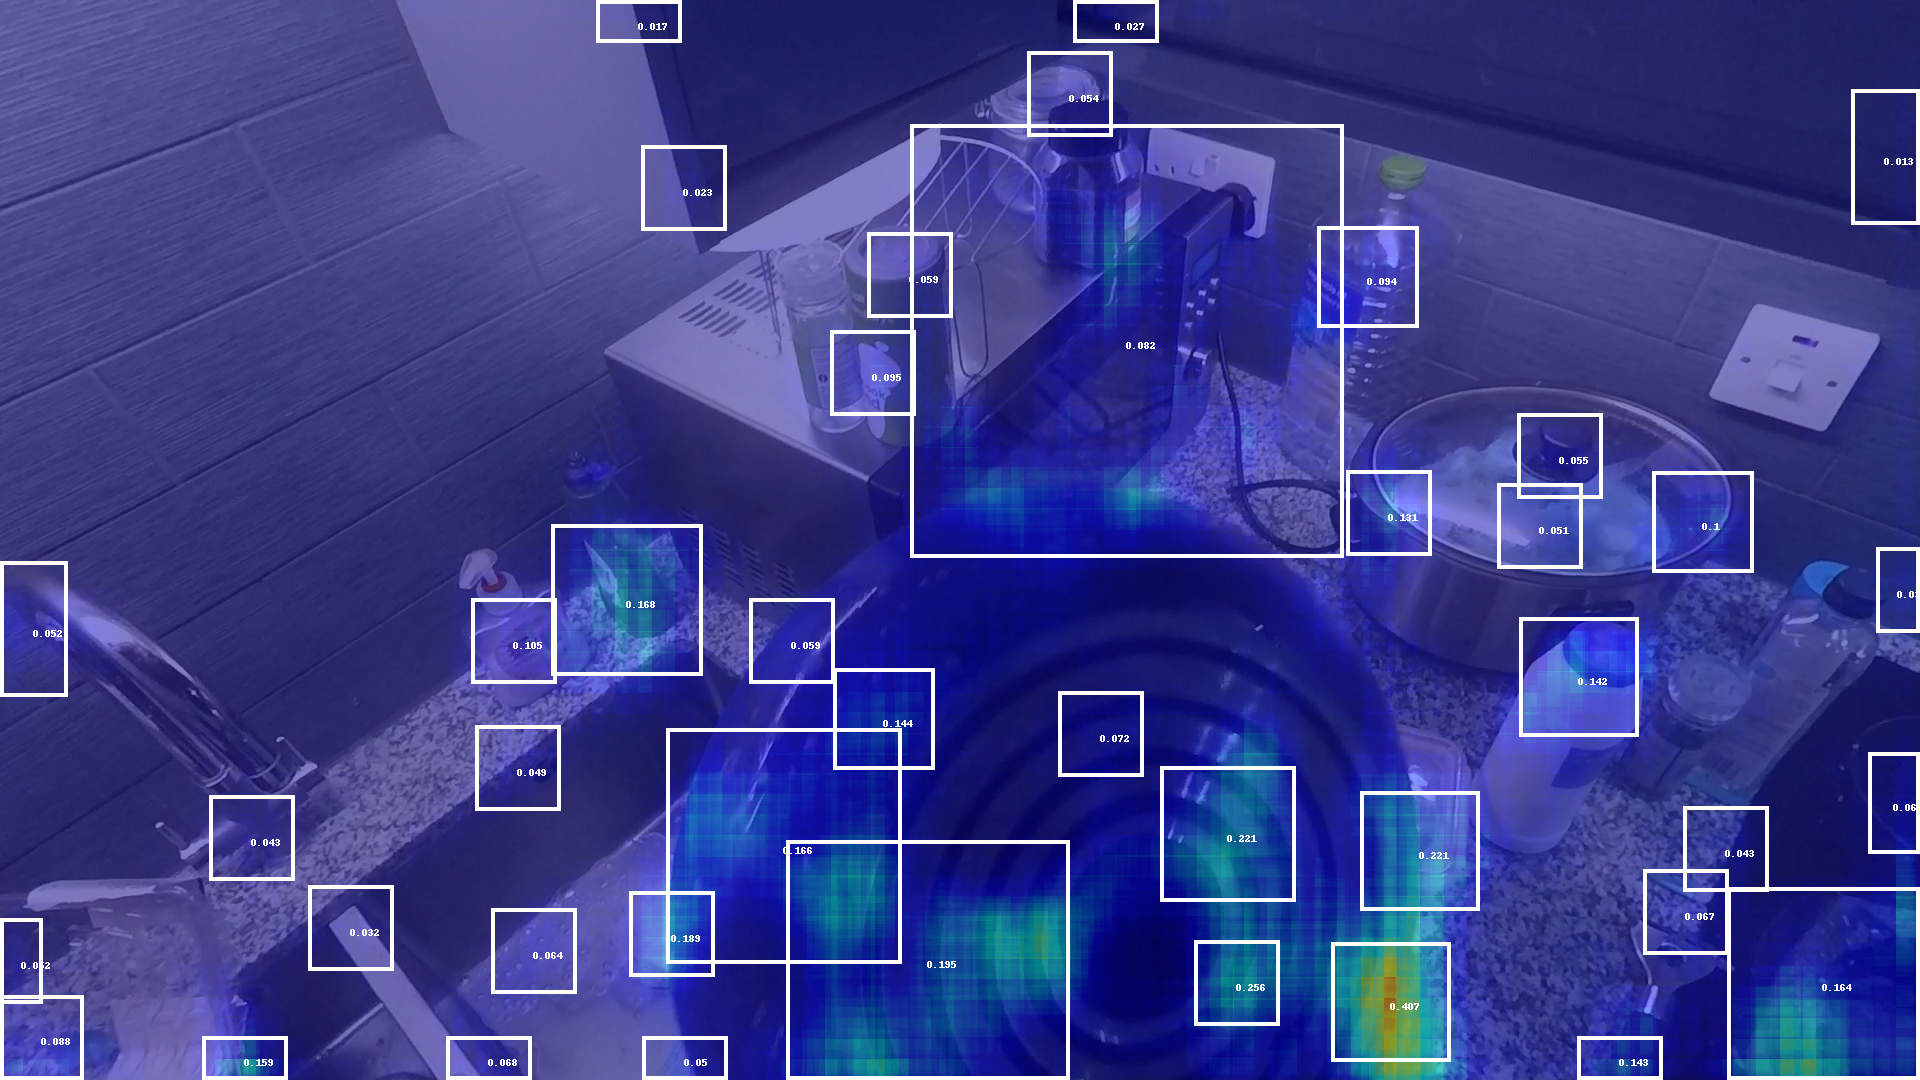

In [7]:
IIII = 5
im_name = im_list[IIII]
hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
fname = os.path.splitext(os.path.basename(im_name))[0]
# roi_name = roi_dir + "/" + os.path.basename(im_name)[:-4] + '_hm.png'

img = Image.open(im_name)
npimg = np.array(img)
hm = np.load(hm_name)
# roi = Image.open(roi_name)

outs = pickle.load(open(f"{out_dir}/{os.path.basename(im_name)[:-3]}.pkl", "rb"))

index = 2
heatmap_img = cv2.applyColorMap((hm[:, :, index]*255.).astype(np.uint8), cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.5, np.array(img), 0.5, 0)[:, :, ::-1]

source_img = Image.fromarray(fin)
boxes = outs[index][0]
scores = outs[index][1]
for ind, bb in enumerate(boxes):
    source_img = draw_bbox(source_img, bb, text=str(scores[ind].round(3)))
source_img

# my_dpi = 96
# fig = plt.figure(frameon=False, figsize=(hm.shape[1]/my_dpi, hm.shape[0]/my_dpi), dpi=my_dpi)
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
# ax.imshow(img)
# ax.imshow(hm[:, :, index], 'Reds', alpha=0.7, vmin=0, vmax=0.5)
# fig.savefig("check.jpg", pad_inches=0)

In [6]:
for image_ind in tqdm(range(len(im_list))):
    im_name = im_list[image_ind]
    hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
    fname = os.path.splitext(os.path.basename(im_name))[0]
    # roi_name = roi_dir + "/" + os.path.basename(im_name)[:-4] + '_hm.png'

    img = Image.open(im_name)
    npimg = np.array(img)
    hm = np.load(hm_name)
    # roi = Image.open(roi_name)
    
    for hm_id in range(hm.shape[2]):
        my_dpi = 96
        fig = plt.figure(frameon=False, figsize=(hm.shape[1]/my_dpi, hm.shape[0]/my_dpi), dpi=my_dpi)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        grasp_name = grasp_names[hm_id].replace(" ", "_")
        ax.imshow(img)
        ax.imshow(hm[:, :, hm_id], 'Reds', alpha=0.5, vmin=0, vmax=0.5)
        os.makedirs(f"{out_dir}/{os.path.basename(im_name)[:-4]}", exist_ok=True)
        fig.savefig(f"{out_dir}/{os.path.basename(im_name)[:-4]}/hm{hm_id}_{grasp_name}.jpg", pad_inches=0)
        plt.close()
    

100%|██████████| 32/32 [07:24<00:00, 13.90s/it]


In [4]:
scales = {i: {'min': float("inf"), 'max': -float("inf")} for i in range(len(grasp_names))}

for image_ind in tqdm(range(len(im_list))):
    im_name = im_list[image_ind]
    hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
    fname = os.path.splitext(os.path.basename(im_name))[0]

    img = Image.open(im_name)
    npimg = np.array(img)
    hm = np.load(hm_name)

    for hm_id in range(hm.shape[2]):
        scales[hm_id]['min'] = min(scales[hm_id]['min'], np.min(hm[:, :, hm_id]))
        scales[hm_id]['max'] = max(scales[hm_id]['max'], np.max(hm[:, :, hm_id]))

for image_ind in tqdm(range(len(im_list))):
    im_name = im_list[image_ind]
    hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
    fname = os.path.splitext(os.path.basename(im_name))[0]

    img = Image.open(im_name)
    npimg = np.array(img)
    hm = np.load(hm_name)

    for hm_id in range(hm.shape[2]):
        hm[:, :, hm_id] = (hm[:, :, hm_id] - scales[hm_id]['min']) / (scales[hm_id]['max'] - scales[hm_id]['min'])
    
    for hm_id in range(hm.shape[2]):
        my_dpi = 96
        fig = plt.figure(frameon=False, figsize=(hm.shape[1]/my_dpi, hm.shape[0]/my_dpi), dpi=my_dpi)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        grasp_name = grasp_names[hm_id].replace(" ", "_")
        ax.imshow(img)
        ax.imshow(hm[:, :, hm_id], 'Reds', alpha=0.5, vmin=0, vmax=0.5)
        os.makedirs(f"{out_dir}_scaled/{os.path.basename(im_name)[:-4]}", exist_ok=True)
        fig.savefig(f"{out_dir}_scaled/{os.path.basename(im_name)[:-4]}/hm{hm_id}_{grasp_name}.jpg", pad_inches=0)
        plt.close()
    

100%|██████████| 32/32 [07:26<00:00, 13.95s/it]


In [7]:
patch_dir = f"./inferred_blobs/epic_benchmark_patches/{model_name}"
os.makedirs(patch_dir, exist_ok=True)

dilation = 2.5
for hm_id in range(33):
    direc = f"{patch_dir}/{hm_id}"
    os.makedirs(direc, exist_ok=True)
    dict = {}
    dict_sum = {}
    img_ind = 0
    for image_ind in tqdm(range(len(im_list))):
        im_name = im_list[image_ind]
        img = Image.open(im_name)
        grasp_name = grasp_names[hm_id].replace(" ", "_")
        heatmapvis = Image.open(f"{out_dir}/{os.path.basename(im_name)[:-4]}/hm{hm_id}_{grasp_name}.jpg")
        hm = np.load(pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy")[:, :, hm_id]
        outs = pickle.load(open(f"{out_dir}/{os.path.basename(im_name)[:-3]}.pkl", "rb"))
        boxes, scores = outs[hm_id]
        
        for indbox, box in enumerate(boxes):
            if box[3] - box[1] == box[2] - box[0]:
                if box[3] - box[1] > 50 and box[2] - box[0] > 50:
                    centerx = box[3]//2 + box[1]//2
                    centery = box[2]//2 + box[0]//2
                    width = (box[3] - box[1]) * dilation
                    height = (box[2] - box[0]) * dilation
                    box_d = [centery - height//2, centerx - width//2, centery + height//2, centerx + width//2]
                    
                    sum_score = np.sum(hm[box[1]:box[3], box[0]:box[2]].astype(np.float32))
                    im_crop = crop_bbox(img, box_d)
#                     fname = f"{hm_id}/{os.path.basename(im_name)[:-4]}_{indbox}_im.jpg"
                    fname = f"{hm_id}/{os.path.basename(im_name)[:-4]}_{indbox}_im.jpg"
                    im_crop.resize((256, 256), resample=Image.ANTIALIAS).save(f"{patch_dir}/{fname}")
                    
                    im_crop = crop_bbox(heatmapvis, box_d)
                    fname = f"{hm_id}/{os.path.basename(im_name)[:-4]}_{indbox}.jpg"
                    dict[fname] = scores[indbox]
                    dict_sum[fname] = sum_score
                    im_crop.resize((256, 256), resample=Image.ANTIALIAS).save(f"{patch_dir}/{fname}")
        with open(f"{patch_dir}/{hm_id}.pkl", "wb") as f:
            pickle.dump(dict, f)
        with open(f"{patch_dir}/{hm_id}_sum.pkl", "wb") as f:
            pickle.dump(dict_sum, f)

100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


In [ ]:
!rm -r /home/mohit/VOS/interaction-hotspots/src_aroundwobj/inferred_blobs/epic_benchmark_patches/SegNetDeeper50_EP55csfixed_eqsampl_twoheads_seed0_350_300/*.html

In [8]:
from html4vision import Col, imagetable

for hm_id in range(33):
    patch_dir = f"./inferred_blobs/epic_benchmark_patches/{model_name}"

    cols = [Col('id1', 'ID')]

    dict = pickle.load(open(f"{patch_dir}/{hm_id}.pkl", "rb"))
    dict = {k: v for k, v in sorted(dict.items(), key=lambda item: -item[1])}
    images = list(dict.keys())
    scores = list(dict.values())
    os.makedirs(f"{patch_dir}/hm{hm_id}_sorted", exist_ok=True)
    print(len(images))
    for i in range(min(len(images), 50)):
        os.system(f"cp {patch_dir}/{images[i]} {patch_dir}/hm{hm_id}_sorted/{str(i).zfill(3)}.jpg")
        os.system(f"cp {patch_dir}/{images[i][:-4]}_im.jpg {patch_dir}/hm{hm_id}_sorted/{str(i).zfill(3)}_im.jpg")
        
    cols += [
        Col('img', grasp_names[hm_id], [f"hm{hm_id}_sorted/{str(i).zfill(3)}.jpg" for i in range(50)]),
        Col('img', grasp_names[hm_id] + "_orig_img", [f"hm{hm_id}_sorted/{str(i).zfill(3)}_im.jpg" for i in range(50)]),
        Col('text', grasp_names[hm_id] + "_scores", [sc.round(3) for sc in scores[:50]]),
    ]


    imagetable(cols, f'{patch_dir}/graspvis_{str(hm_id).zfill(2)}.html', 'Object affordances',
               imscale=1.0,  # scale images to 0.4 of the original size
               sortcol=3,  # initially sort based on column 2 (class average performance)
               sortable=True,  # enable interactive sorting
               sticky_header=True,  # keep the header on the top
               sort_style='materialize',  # use the theme "materialize" from jquery.tablesorter
               )

556
1248
917
1288
1182
143
568
222
131
506
124
27
74
6
1048
1184
1117
1341
866
890
564
860
768
174
721
73
41
687
1019
1107
142
925
343
